## Import Libraries and setup

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

## Main Functions

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [3]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [4]:
def _extract_heartbeats(signal=None, rpeaks=None, before=200, after=400):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [5]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.2, after=0.4):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [6]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.2,after=0.4)
    if plot:
        ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

In [7]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

In [8]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

## Getting Test data

In [20]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [21]:
df = df.loc[df.rhythm_diag != 'OTHER']

In [22]:
df['rhythm_diag'] = df['rhythm_diag'].map(dict(AFIB=1, SR=0))
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [23]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])

In [24]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [25]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [26]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [27]:
X_sr = df_sr.values
X_afib = df_afib.values

In [28]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

In [29]:
X_sr = get_heart_beat(X_sr)
X_sr.shape

(15369, 60)

In [19]:
y_sr = np.zeros(len(X_sr))
y_sr.shape

(15369,)

In [20]:
X_afib = get_heart_beat(X_afib)
X_afib.shape

(19039, 60)

In [21]:
y_afib = np.ones(len(X_afib))
y_afib.shape

(19039,)

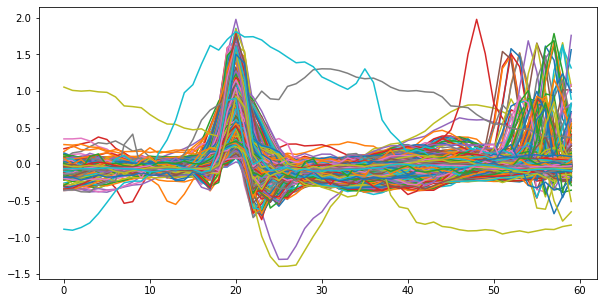

In [23]:
for i in range(1000):
    plt.plot(X_afib[i])

In [22]:
X = np.concatenate((X_sr, X_afib), axis=0)
X.shape

(34408, 60)

In [23]:
y = np.concatenate((y_sr, y_afib), axis=0)
y.shape

(34408,)

In [24]:
# Getting data
from numpy import load
#Xt = load('../data/train_test_data/X.npy')
#yt = load('../data/train_test_data/y.npy')
Xt = X
yt = y

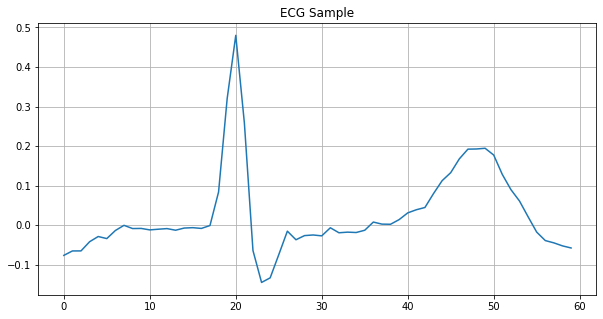

In [25]:
plt.plot(Xt[0])
plt.title("ECG Sample")
plt.grid()
plt.show()

In [26]:
# Split data, normalize and reshape
X_train, X_test, y_train, y_test = train_test_split(Xt,yt,
                                                    test_size=0.20,
                                                    random_state=21)

In [27]:
X_train_full = []
for i in range(len(X_train)-1):
    norm = ((X_train[i] - X_train[i].min())/(X_train[i].max() - X_train[i].min()))
    X_train_full.append(norm)

In [28]:
X_train_full = np.array(X_train_full)
X_train_full.shape

(27525, 60)

In [29]:
X_test_full = []
for i in range(len(X_test)-1):
    norm = ((X_test[i] - X_test[i].min())/(X_test[i].max() - X_test[i].min()))
    X_test_full.append(norm)

In [30]:
X_test_full = np.array(X_test_full)
X_test_full.shape

(6881, 60)

In [32]:
X_train_full = np.expand_dims(X_train_full, 2)
X_test_full = np.expand_dims(X_test_full, 2)

In [33]:
print(X_train_full.shape, X_test_full.shape)
samples, features, depht = X_train_full.shape

(27525, 60, 1) (6881, 60, 1)


In [34]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [35]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model=group_layer(model)
model=group_layer(model)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 32)            5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 32)            5

In [37]:
lr = 0.001

In [38]:
opt = Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [39]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=25)

In [40]:
EPOCHS = 50

history = model.fit(X_train_full,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
689/689 [==============================] - 7s 9ms/step - loss: 0.3999 - accuracy: 0.8284 - val_loss: 0.3254 - val_accuracy: 0.8730
Epoch 2/50
689/689 [==============================] - 6s 9ms/step - loss: 0.3047 - accuracy: 0.8808 - val_loss: 0.2864 - val_accuracy: 0.8912
Epoch 3/50
689/689 [==============================] - 6s 9ms/step - loss: 0.2818 - accuracy: 0.8884 - val_loss: 0.3125 - val_accuracy: 0.8765
Epoch 4/50
689/689 [==============================] - 6s 9ms/step - loss: 0.2690 - accuracy: 0.8948 - val_loss: 0.2593 - val_accuracy: 0.9028
Epoch 5/50
689/689 [==============================] - 6s 9ms/step - loss: 0.2601 - accuracy: 0.8980 - val_loss: 0.3007 - val_accuracy: 0.8797
Epoch 6/50
689/689 [==============================] - 6s 9ms/step - loss: 0.2538 - accuracy: 0.9018 - val_loss: 0.3073 - val_accuracy: 0.8776
Epoch 7/50
689/689 [==============================] - 6s 9ms/step - loss: 0.2484 - accuracy: 0.9046 - val_loss: 0.2545 - val_accuracy: 0.9017
Epoch 

In [41]:
# summarize history for loss
def summarize_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [47]:
y_test = np.delete(y_test, 6881)

Model Accuraccy:  0.92


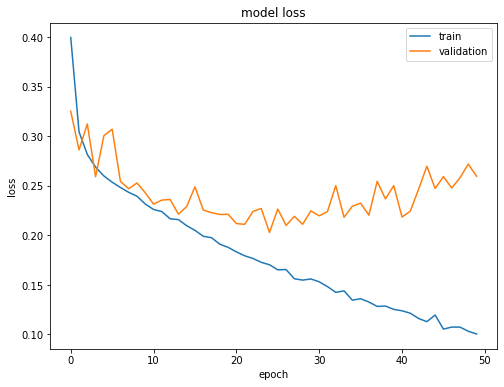

In [50]:
_, model_accuracy = model.evaluate(X_test_full, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [51]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

In [52]:
y_pred = model.predict(X_test_full)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.90      0.91      0.91      3083
        AFIB       0.93      0.92      0.92      3798

    accuracy                           0.92      6881
   macro avg       0.92      0.92      0.92      6881
weighted avg       0.92      0.92      0.92      6881



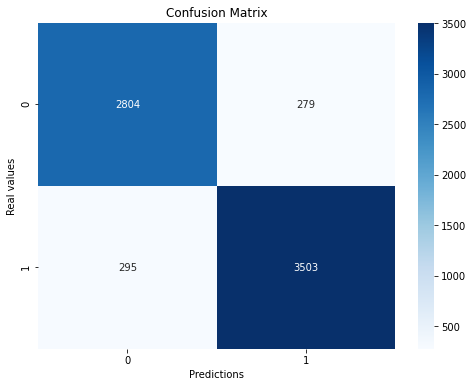

In [53]:
y_pred = model.predict(X_test_full)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [54]:
for i in range (10):
    ecg_pred = model.predict(X_test_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    print(ecg_pred)

True
False
True
False
True
False
True
False
False
True


In [55]:
y_test[:10]

array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])

In [56]:
X_sr_full = []
for i in range(len(X_sr)-1):
    norm = ((X_sr[i] - X_sr[i].min())/(X_sr[i].max() - X_sr[i].min()))
    X_sr_full.append(norm)
X_sr_full = np.array(X_sr_full)

In [57]:
for i in range(20):
    ecg_pred = model.predict(X_sr_full[i].T.reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    print(ecg_pred)

False
False
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
False
False
False


In [58]:
X_afib_full = []
for i in range(len(X_afib)-1):
    norm = ((X_afib[i] - X_afib[i].min())/(X_afib[i].max() - X_afib[i].min()))
    X_afib_full.append(norm)
X_afib_full = np.array(X_afib_full)

In [59]:
for i in range(20):
    ecg_pred = model.predict(X_afib_full[i].T.reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    print(ecg_pred)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Testing with real data

### Real person with no heart condition

In [60]:
df = pd.read_csv("ecg_homecare_data_10_s_100Hz_ADS1115.csv")
df.shape

(12965, 3)

In [61]:
df.head(2)

,time,Unnamed: 1,samples
0,15:56:57,57417.7,23
1,15:56:57,57417.7,36


In [62]:
X = df['samples'].values.astype('float32')
X.shape

(12965,)

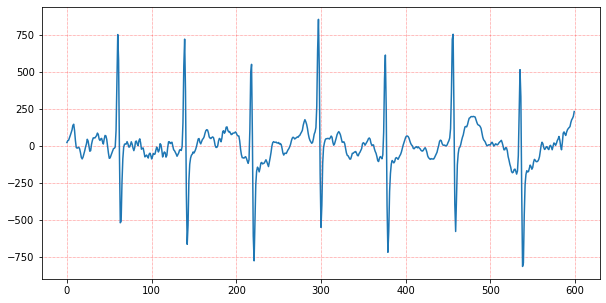

In [63]:
plt.plot(X[:600])
plt.grid(color='r', linestyle=':', linewidth=0.5);

In [64]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)
X_sr.shape

(163, 60)

In [65]:
X_sr_full = []
for i in range(len(X_sr)-1):
    norm = ((X_sr[i] - X_sr[i].min())/(X_sr[i].max() - X_sr[i].min()))
    X_sr_full.append(norm)
X_sr_full = np.array(X_sr_full)
print (X_sr_full.min(), X_sr_full.max())

0.0 1.0


In [66]:
X_sr_full.shape

(162, 60)

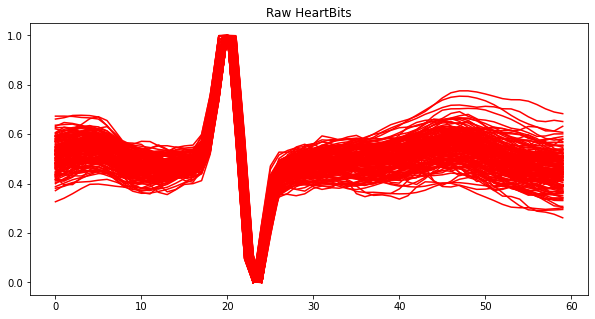

In [68]:
for i in range(len(X_sr_full)):
    plt.plot(X_sr_full[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [69]:
pred = []
for i in range (len(X_sr_full)):
    ecg_pred = model.predict(X_sr_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  72


### Boneco with no heart condition and no noise

(3043,)


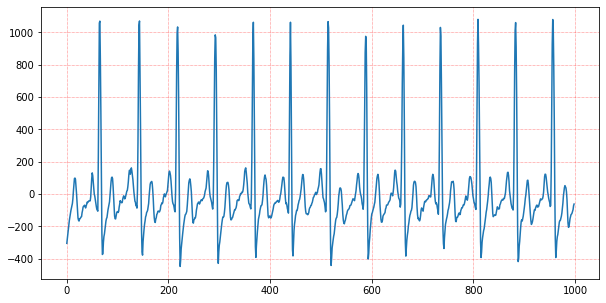

In [79]:
#df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')
print(X.shape)
plt.plot(X[:999])
plt.grid(color='r', linestyle=':', linewidth=0.5);
                 

In [80]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)
print("Number of samples: ", X_sr.shape[0])
X_sr_full = []
for i in range(len(X_sr)-1):
    norm = ((X_sr[i] - X_sr[i].min())/(X_sr[i].max() - X_sr[i].min()))
    X_sr_full.append(norm)
X_sr_full = np.array(X_sr_full)

Number of samples:  40


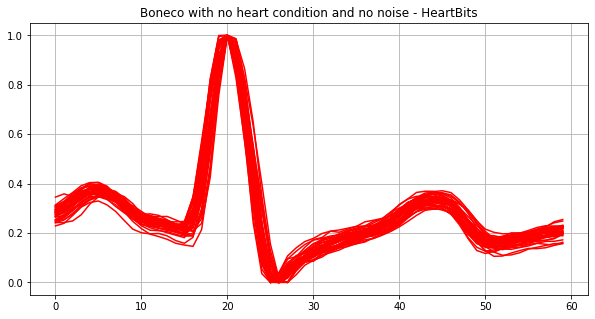

In [81]:
for i in range(len(X_sr_full)):
    plt.plot(X_sr_full[i], color = 'r')
    plt.title("Boneco with no heart condition and no noise - HeartBits")
    plt.grid()

In [82]:
pred = []
for i in range (len(X_sr_full)):
    ecg_pred = model.predict(X_sr_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  18


### Boneco with no heart condition and with noise

(3976,)


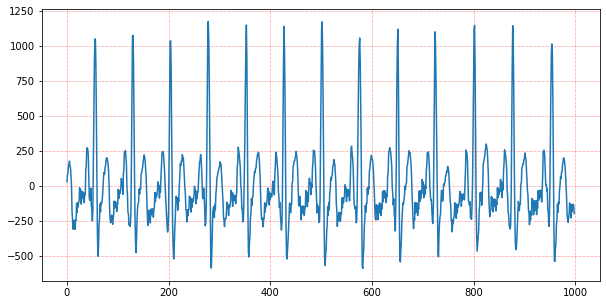

In [72]:
#df = pd.read_csv("../data//Real_Colected_data/ecg_data_boneco_sr_com_ruido.csv")
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')
print(X.shape)
plt.plot(X[:999])
plt.grid(color='r', linestyle=':', linewidth=0.5);

Number of samples:  52


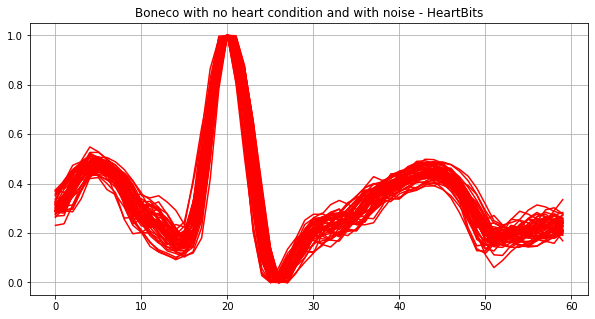

In [73]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)
print("Number of samples: ", X_sr.shape[0])
X_sr_full = []
for i in range(len(X_sr)-1):
    norm = ((X_sr[i] - X_sr[i].min())/(X_sr[i].max() - X_sr[i].min()))
    X_sr_full.append(norm)
X_sr_full = np.array(X_sr_full)

for i in range(len(X_sr_full)):
    plt.plot(X_sr_full[i], color = 'r')
    plt.title("Boneco with no heart condition and with noise - HeartBits")
    plt.grid()

In [74]:
pred = []
for i in range (len(X_sr_full)):
    ecg_pred = model.predict(X_sr_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  4


### Boneco with heart condition (AFIB) and no noise

(8518,)


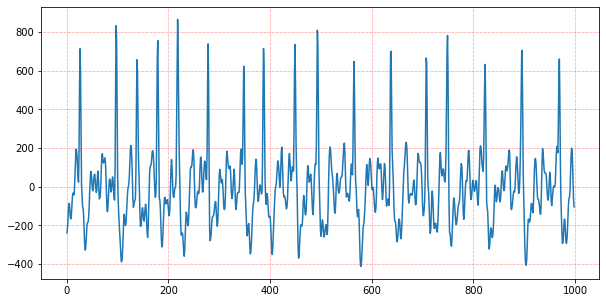

In [75]:
#df = pd.read_csv("../data//Real_Colected_data/ecg_data_boneco_afib_sem_ruido.csv")
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')
print(X.shape)
plt.plot(X[:999])
plt.grid(color='r', linestyle=':', linewidth=0.5);

Number of samples:  138


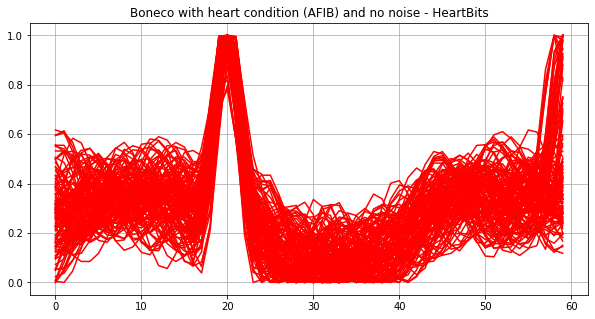

In [76]:
X_afib = get_complete_Heartbit(X, sampling_rate=100, plot=False)
print("Number of samples: ", X_afib.shape[0])
X_afib_full = []
for i in range(len(X_afib)-1):
    norm = ((X_afib[i] - X_afib[i].min())/(X_afib[i].max() - X_afib[i].min()))
    X_afib_full.append(norm)
X_afib_full = np.array(X_afib_full)

for i in range(len(X_afib_full)):
    plt.plot(X_afib_full[i], color = 'r')
    plt.title("Boneco with heart condition (AFIB) and no noise - HeartBits")
    plt.grid()

In [77]:
pred = []
for i in range (len(X_afib_full)):
    ecg_pred = model.predict(X_afib_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  124


### Boneco with heart condition(AFIB) and with noise

(9068,)


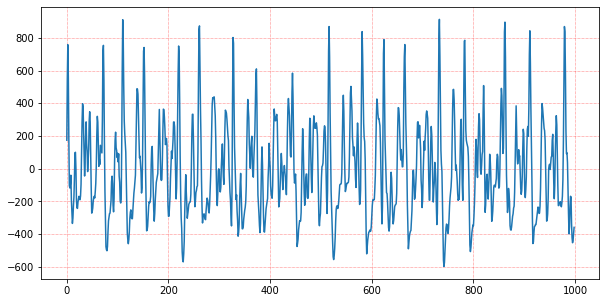

In [83]:
df = pd.read_csv("ecg_data_boneco_afib_com_ruido.csv")
X = df['values'].values.astype('float32')
print(X.shape)
plt.plot(X[:999])
plt.grid(color='r', linestyle=':', linewidth=0.5);

Number of samples:  107


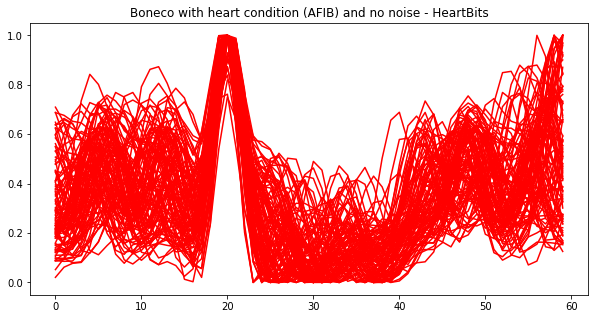

In [84]:
X_afib = get_complete_Heartbit(X, sampling_rate=100, plot=False)
print("Number of samples: ", X_afib.shape[0])
X_afib_full = []
for i in range(len(X_afib)-1):
    norm = ((X_afib[i] - X_afib[i].min())/(X_afib[i].max() - X_afib[i].min()))
    X_afib_full.append(norm)
X_afib_full = np.array(X_afib_full)

for i in range(len(X_afib_full)):
    plt.plot(X_afib_full[i], color = 'r')
    plt.title("Boneco with heart condition (AFIB) and no noise - HeartBits")
    plt.grid()

In [85]:
pred = []
for i in range (len(X_afib_full)):
    ecg_pred = model.predict(X_afib_full[i].reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  83
